# Final project Digital Signals Proccesing.

* Julián Mauricio Sanchez Ceballos
* Maverick Sosa




In [ ]:
# For Local run follow the below steps:
# 1. Create a virtual environment by the command
#    python3 -m venv venv
# 2. Activate the virtual environment by the command
#    source venv/bin/activate
# 3. Install the required packages in this code cell by the command
#    %pip install package_name -q


# Required packages
%pip install numpy -q 
%pip install scipy -q
%pip install matplotlib -q
%pip install librosa -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# importing the required packages
import numpy as np
import scipy as sp
from scipy import signal, stats
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio


## Design Considerations

In order to guide the design process effectively, the following considerations have been established as preliminary parameters:

1. **Audio Sample Selection**: For testing purposes, a one-minute excerpt of the *Imperial March* will be used as the audio sample.
2. **Sampling Frequency**: The sampling frequency is fixed at $44.1\,\text{kHz}$.
3. **Frequency Band Definitions**: The classification of frequency ranges is defined as follows:
    - **Low Frequencies**: $f < 250\,\text{Hz}$
    - **Medium Frequencies**: $250\,\text{Hz} \leq f \leq 4\,\text{kHz}$
    - **High Frequencies**: $f > 4\,\text{kHz}$
4. **Filter Specifications**: The design parameters for all filters are as follows:
    - **Maximum Ripple**: Approximately $0.001\,\text{V}$
    - **Transition Bandwidth**: $100\,\text{Hz}$

These parameters serve as foundational constraints and targets for the design and implementation of the signal processing components.


In [13]:
fs = 44100  # Sampling frequency
path = "Imperial_March.flac"

imperial_march, _ = librosa.load(path, sr=fs)

duration = 60
start = 1
end = start+1                   # Duration in seconds
imperial_march = imperial_march[(fs*duration)*(start):(fs * duration)*(end)]   # Keep only the first 60 seconds

t = np.linspace(0, duration, len(imperial_march))
imperial_march /= max(imperial_march)

Audio(imperial_march, rate=fs)           # Display the audio player




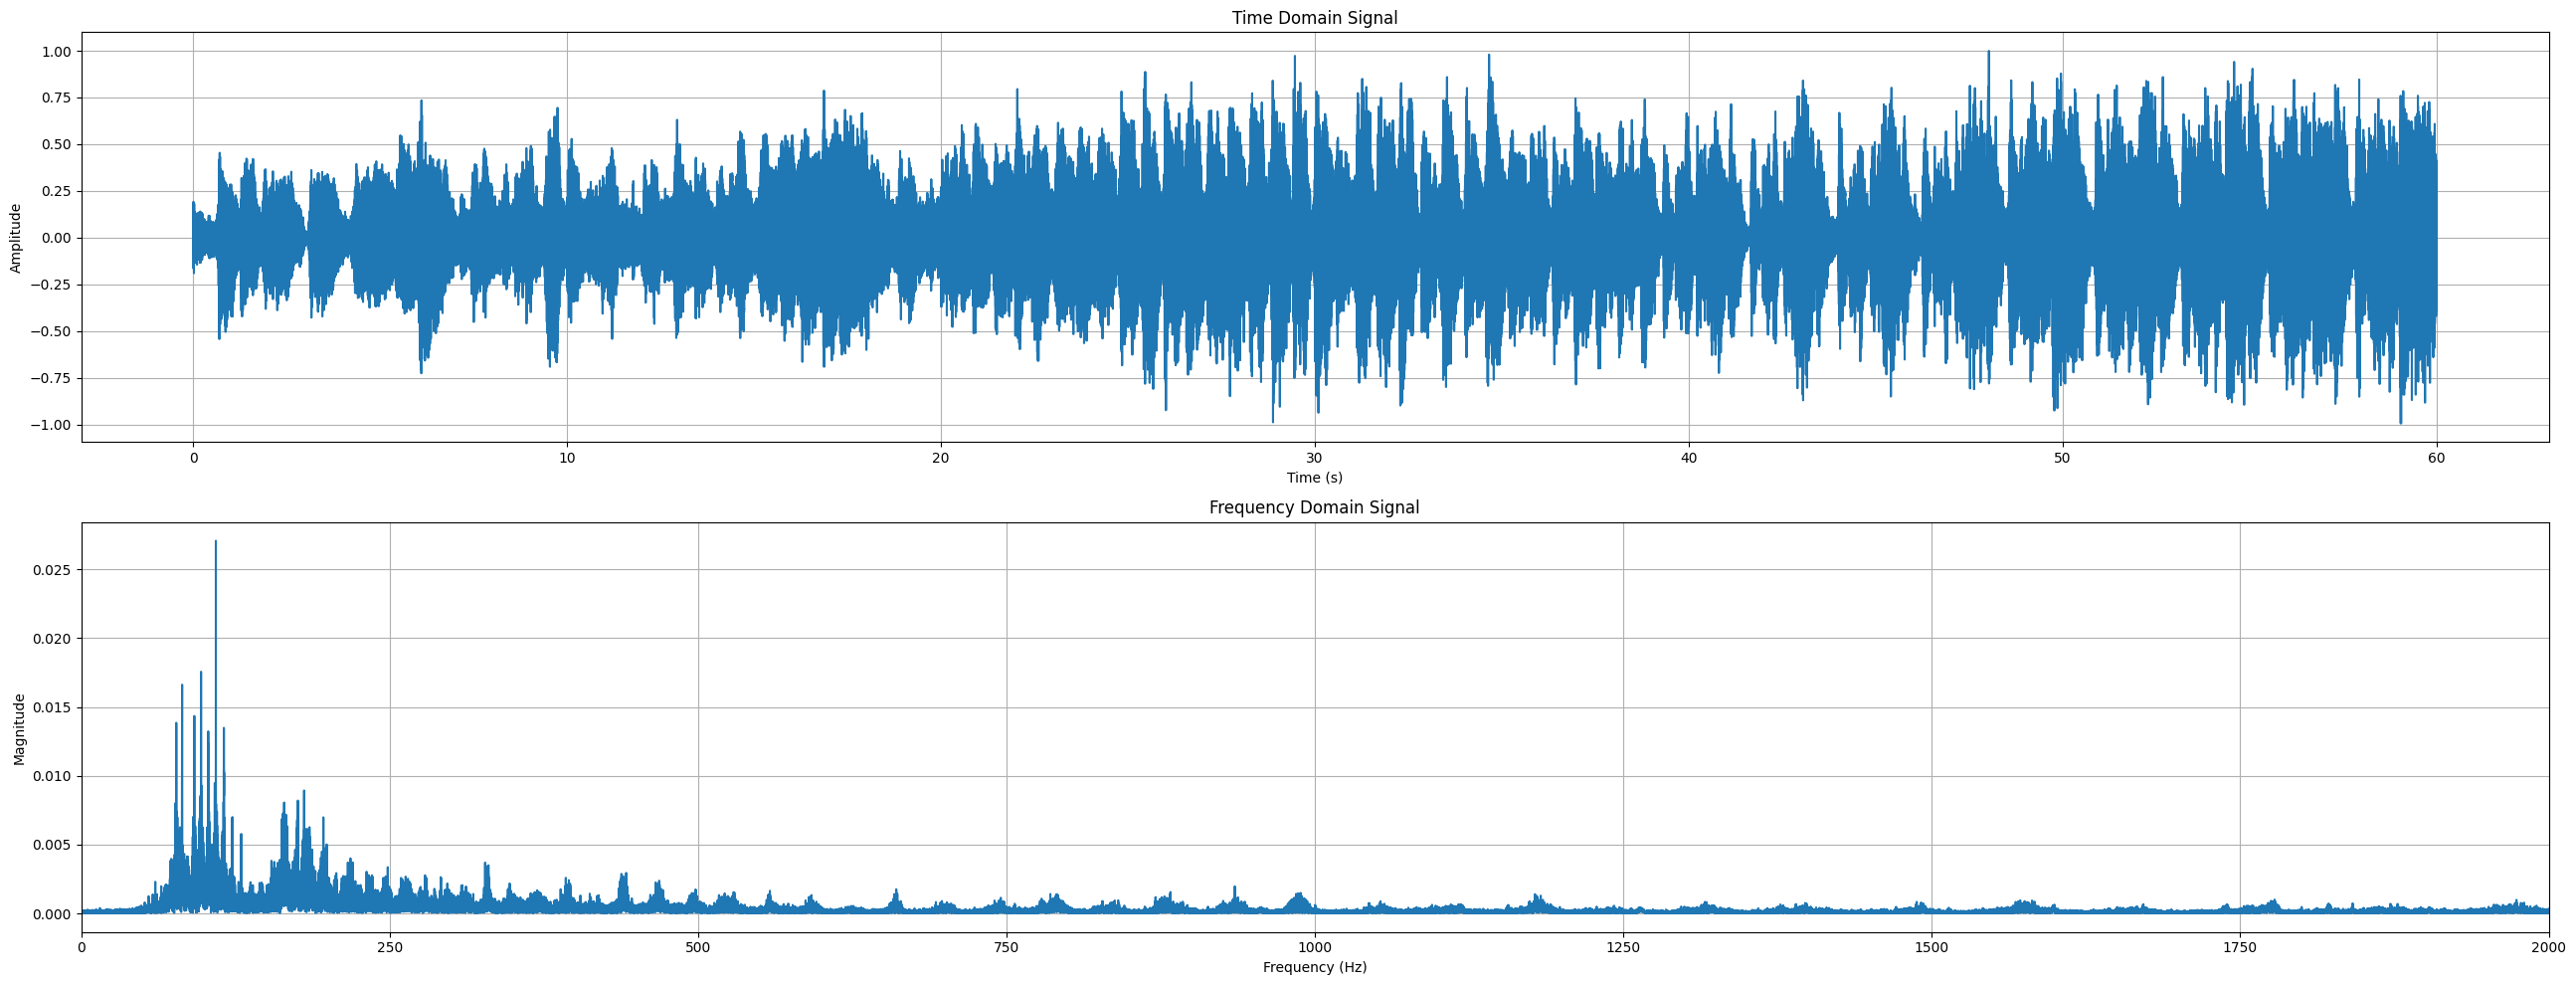

In [14]:
# time, frecuency and spectrogram graphs

fft_imperial_march = np.fft.fft(imperial_march)
freq_imperial_march = fs*np.fft.fftfreq(len(imperial_march))

fig, axs = plt.subplots(2, 1, figsize=(26, 10))
axs[0].plot(t, imperial_march)
axs[0].set_title("Time Domain Signal")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].grid()

axs[1].plot(freq_imperial_march[:len(freq_imperial_march)//2], (2/len(imperial_march))*np.abs(fft_imperial_march)[:len(freq_imperial_march)//2])
axs[1].set_title("Frequency Domain Signal")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Magnitude")
axs[1].set_xlim(0, 2000)  # Limit x-axis to 2000 Hz for better visibility
axs[1].grid()
plt.tight_layout()
plt.show()




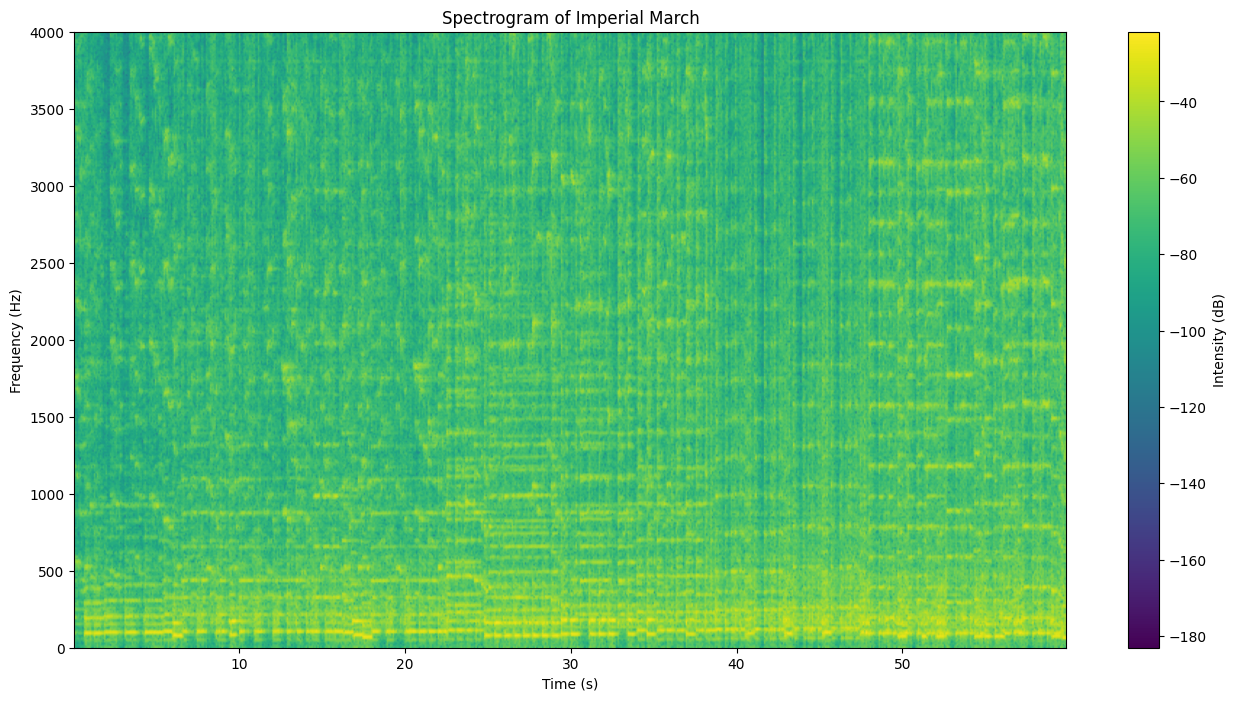

In [ ]:
# Spectrogram

N = fs*100e-3                                                           # Window length of 100 ms
n_window = np.arange(0, N, 1)                                           # Create a time vector for the window

window = 25/46 - (1-(25/46))*np.cos(2*np.pi*n_window/(N-1))             # Kaiser window with beta = 25/46

# Calculate the spectrogram using the window 
f, time, Sxx = signal.spectrogram(imperial_march, fs=fs, window=window)

# Plotting the spectrogram
plt.figure(figsize=(16, 8))
plt.pcolormesh(time, f, 10 * np.log10(Sxx), shading='gouraud')
plt.title("Spectrogram of Imperial March")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Intensity (dB)')
plt.ylim(0, 4000)                                                       # Limit y-axis to 2000 Hz for better visibility
plt.show()


As observed, the majority of significant frequency components are located below $4\,\text{kHz}$. This observation aligns with the nature of the analyzed signal — an orchestral composition — where most instruments exhibit their fundamental frequencies within this range. The spectral characteristics are therefore consistent with expectations for this type of audio content.


## 1. Low-Pass Filter Design

### 1.1 Window Design

Based on the previously defined specifications, the maximum allowable ripple in the passband is given in decibels by:

$$
20\log_{10}(0.001) = -60\,\text{dB}
$$

According to the methodology discussed in class, the Hamming window provides a good balance between main-lobe width and side-lobe attenuation. The minimum number of coefficients $M$ required to achieve the desired transition bandwidth $\Delta F_m$ is determined by the following condition:

$$
\Delta \omega \leq \Delta \omega_m
$$

Using the relationship between digital and normalized frequencies:

$$
\frac{8\pi}{M} \leq \frac{2\pi \Delta F_m}{F_s}
$$

Solving for $M$:

$$
M \geq \frac{4F_s}{\Delta F_m}
$$

Substituting the values $F_s = 44100\,\text{Hz}$ and $\Delta F_m = 100\,\text{Hz}$:

$$
M \geq \frac{4 \cdot 44100}{100} = 1764
$$

To ensure the filter is causal (i.e., the impulse response is right-sided), we round up to the next odd integer:

$$
M = 1765
$$

Finally, the Hamming window function is defined as:

$$
w[n] = 0.54 - 0.46 \cos\left(\frac{2\pi n}{M - 1}\right), \quad 0 \leq n \leq M - 1
$$

This window is applied to the ideal low-pass filter impulse response to obtain a realizable finite impulse response (FIR) filter with reduced side lobes and a smoother transition band.



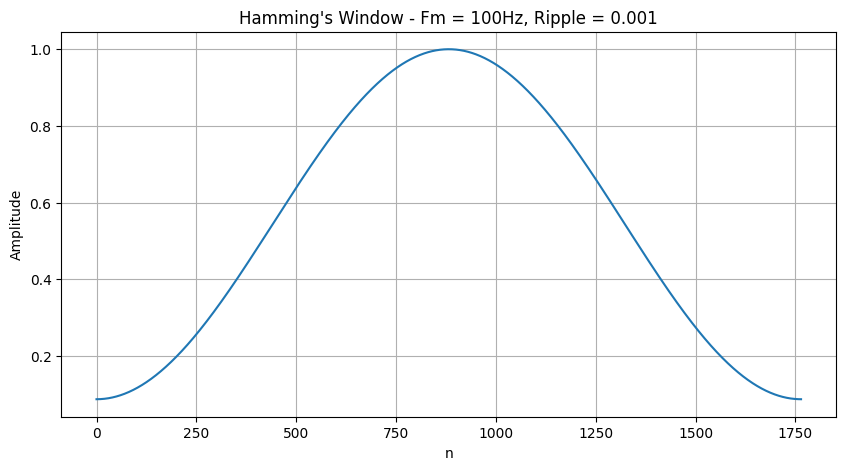

In [21]:
M = 1765
ao = 25/46
a1 = 1 - ao
n = np.arange(0, M,1)
hamming_window = ao - a1*np.cos(2*np.pi*n/(M-1))


plt.figure(figsize=(10, 5))
plt.plot(n,hamming_window)
plt.title("Hamming's Window - Fm = 100Hz, Ripple = 0.001")
plt.xlabel("n")
plt.ylabel("Amplitude")
plt.grid(True)